In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import input_data

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [23]:
batch_size = 100
epochs_n = 10
latent_dim = 2 
x_dim = 784
y_dim = 10
input_dim = x_dim + y_dim
learning_rate = 0.001

# Specify num layers
encoder_h1_n = 500
encoder_h2_n = 500
generator_h1_n = 500
generator_h2_n = 500

x = tf.placeholder(tf.float32, (None, input_dim))

# Inititialize recognition network weights q(z|x,y)
W_enc_h1 = tf.Variable(xavier_init(input_dim, encoder_h1_n),dtype=tf.float32)
b_enc_h1 = tf.Variable(tf.zeros(encoder_h1_n),dtype=tf.float32)
W_enc_h2 = tf.Variable(xavier_init(encoder_h1_n, encoder_h2_n),dtype=tf.float32)
b_enc_h2 = tf.Variable(tf.zeros(encoder_h2_n),dtype=tf.float32)

## Mean and Variance aka variatioal param, weights for q(z|x,y)
W_enc_out_mu = tf.Variable(xavier_init(encoder_h2_n, latent_dim),dtype=tf.float32)
b_enc_out_mu = tf.Variable(tf.zeros(latent_dim),dtype=tf.float32)
W_enc_out_sigma = tf.Variable(xavier_init(encoder_h2_n, latent_dim),dtype=tf.float32)
b_enc_out_sigma = tf.Variable(tf.zeros(latent_dim),dtype=tf.float32)

## Setup recognition network q_phi(z|x,y)
enc_layer_1 = tf.nn.softplus(tf.add(tf.matmul(x, W_enc_h1), b_enc_h1))
enc_layer_2 = tf.nn.softplus(tf.add(tf.matmul(enc_layer_1, W_enc_h2), b_enc_h2))
enc_mu = tf.add(tf.matmul(enc_layer_2, W_enc_out_mu), b_enc_out_mu)
enc_log_sigma_sq = tf.add(tf.matmul(enc_layer_1, W_enc_out_mu), b_enc_out_mu)

## Reparam Trick: z = mu + sigma*epsilon => z ~ N(mu,sigma^2)
eps = tf.random_normal((batch_size, latent_dim), dtype=tf.float32)
z = tf.add(enc_mu, tf.multiply(tf.sqrt(tf.exp(enc_log_sigma_sq)),eps))

# Setup generator Network
## Initiazlie weights for generator/decoder network
W_gen_h1 = tf.Variable(xavier_init(latent_dim, generator_h1_n),dtype=tf.float32)
b_gen_h1 = tf.Variable(tf.zeros(generator_h1_n),dtype=tf.float32)
W_gen_h2 = tf.Variable(xavier_init(generator_h1_n, generator_h2_n),dtype=tf.float32)
b_gen_h2 = tf.Variable(tf.zeros(generator_h2_n),dtype=tf.float32)
W_gen_out = tf.Variable(xavier_init(generator_h2_n, input_dim),dtype=tf.float32)
b_gen_out = tf.Variable(tf.zeros(input_dim),dtype=tf.float32)

## Setup the generator/decoder network
gen_layer_1 = tf.nn.softplus(tf.add(tf.matmul(z,W_gen_h1),b_gen_h1))
gen_layer_2 = tf.nn.softplus(tf.add(tf.matmul(gen_layer_1,W_gen_h2),b_gen_h2))
x_mean = tf.nn.sigmoid(tf.add(tf.matmul(gen_layer_2,W_gen_out),b_gen_out))

# Marginal Likelihood
# Compute Loss
## Reconstruction Loss: -p(x|z)
recon_loss = -tf.reduce_sum(tf.multiply(x, tf.log(1e-10 + x_mean)) + tf.multiply((1-x),tf.log(1e-10 +1-x_mean)))
                       
## Latent Loss: KL[q(z|x)||p(z)]
latent_loss = -.5*tf.reduce_sum(1 + enc_log_sigma_sq - tf.square(enc_mu) - tf.exp(enc_log_sigma_sq))

total_loss = tf.reduce_mean(recon_loss + latent_loss)

# Setup optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(total_loss)

In [24]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
    
for i in range(epochs_n):
    epoch_loss = 0.
    batches_n = int(n_samples / batch_size)

    for _ in range(batches_n):
        batch, _ = mnist.train.next_batch(batch_size)
        _, loss_batch = sess.run((optimizer,total_loss), feed_dict={x: batch})
        epoch_loss += loss_batch
    print('Average loss epoch {0}: {1}'.format(i, epoch_loss/batches_n))   

Average loss epoch 0: 19285.434517
Average loss epoch 1: 16784.3897674
Average loss epoch 2: 16229.3883008
Average loss epoch 3: 15869.0635778
Average loss epoch 4: 15595.7110458
Average loss epoch 5: 15399.8256942
Average loss epoch 6: 15232.8672106
Average loss epoch 7: 15133.7494354
Average loss epoch 8: 15046.6271413
Average loss epoch 9: 14970.0809659


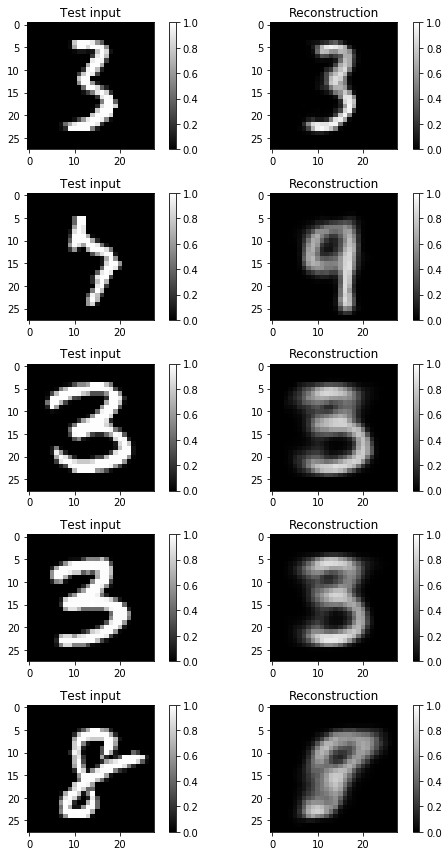

In [27]:
# Use VAE to reconstruct given data.
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = sess.run(x_mean, feed_dict={x: x_sample})

plt.figure(figsize=(8, 12))

for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    plt.tight_layout()


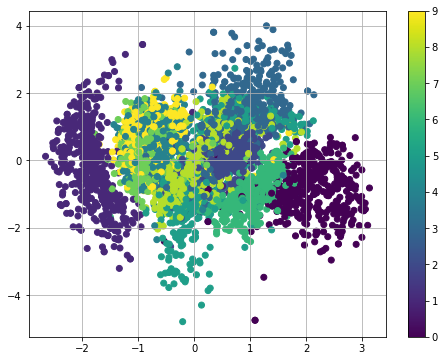

In [34]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = sess.run(enc_mu, feed_dict={x: x_sample})
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()